# Gauss curvature approximation directly on surface

In this tutorial we compute a finite element approximation of the Gaussian curvature of a triangulated surface $\mathcal{S}$, and we study its convergence under refinement.  The finite element method seeks $K_h \in V_h^q$ (the Lagrange finite element space of degree $q$) such that for all $\varphi \in V_h^q$, 

\begin{align*}
\int_{\mathcal{S}} K_h \varphi \,ds = \sum_{V \in \mathcal{V}_h} \Theta_V \varphi(V) + \sum_{E \in \mathcal{E}_h} \int_E [\![ \kappa_g ]\!] \varphi d\ell + \sum_{T \in \mathcal{T}_h} \int_T K|_T \varphi ds.
\end{align*}
Here $K|_T$ is the Gaussian curvature in the interior of triangle $T$, $[\![\kappa_g]\!]$ is the jump in the geodesic curvature $\kappa_g = \mu \cdot \nabla_t t$ across the edge $E$, and 

\begin{align*}
\Theta_V = 2\pi-\sum_{T:V\subset T}\sphericalangle_V^T
\end{align*}
is the angle defect at the vertex $V$.

First we define a few functions that are needed to compute $K$, $\kappa_g$, and $\Theta_V$.

In [1]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw
import random as random
from ngsolve.krylovspace import CGSolver


# Gauss curvature
def GaussCurv():
    nsurf = specialcf.normal(3)
    return Cof(Grad(nsurf)) * nsurf * nsurf


# geodesic curvature
mu = Cross(specialcf.normal(3), specialcf.tangential(3))
edgecurve = specialcf.EdgeCurvature(3)  # nabla_t t

# for angle deficit
bbnd_tang = specialcf.VertexTangentialVectors(3)
bbnd_tang1 = bbnd_tang[:, 0]
bbnd_tang2 = bbnd_tang[:, 1]

Next we define a function that computes the $H^{-1}$-norm of a functional $f$, using the fact that $||f||_{H^{-1}}$ is equivalent to $\|u\|_{H^1}$ if $-\Delta u = f$.  We will use this function later on to compute the error in the discrete Gaussian curvature.

In [2]:
# H^-1 norm
def CompHm1Norm(rhs, order):
    fesH = H1(mesh, order=order)
    u, v = fesH.TnT()

    a = BilinearForm(
        (Grad(u).Trace() * Grad(v).Trace() + u * v) * ds,
        symmetric=True,
        symmetric_storage=True,
        condense=True,
    )
    f = LinearForm(rhs * v * ds).Assemble()

    apre = Preconditioner(a, "bddc")
    a.Assemble()
    invS = CGSolver(a.mat, apre.mat, printrates="", maxiter=400)
    ext = IdentityMatrix() + a.harmonic_extension
    inv = a.inner_solve + ext @ invS @ ext.T

    gfu = GridFunction(fesH)
    gfu.vec.data = inv * f.vec

    err = sqrt(Integrate(gfu**2 + Grad(gfu) ** 2, mesh, BND))
    return err

Next we define a function that computes $K_h = \sum_i c_i \varphi_i$ by solving the linear system $Mc=f$, where $M_{ij} = \int_{\mathcal{S}} \varphi_i \varphi_j ds$ and 

\begin{align*}
f_i = \sum_{V \in \mathcal{V}_h} \Theta_V \varphi_i(V) + \sum_{E \in \mathcal{E}_h} \int_E [\![ \kappa_g ]\!] \varphi_i d\ell + \sum_{T \in \mathcal{T}_h} \int_T K|_T \varphi_i ds.
\end{align*}
After computing $K_h$, the function outputs the errors $||K_h-K||_{H^{-1}}$ and $||K_h-K||_{L^2}$.

In [3]:
def ComputeCurv(mesh, order, Kex):
    fes = H1(mesh, order=order)
    u, v = fes.TnT()

    f = LinearForm(fes)
    f += GaussCurv() * v * ds
    f += -edgecurve * mu * v * ds(element_boundary=True)  # element_vb=BND
    f += -v * acos(bbnd_tang1 * bbnd_tang2) * ds(element_vb=BBND)

    M = BilinearForm(u * v * ds, symmetric=True, symmetric_storage=True, condense=True)

    gfK = GridFunction(fes)

    with TaskManager():
        f.Assemble()
        # angle deficit (no boundary)
        for i in range(mesh.nv):
            f.vec[i] += 2 * pi

        Mpre = Preconditioner(M, "bddc")
        M.Assemble()
        invS = CGSolver(M.mat, Mpre.mat, printrates="", maxiter=400)
        ext = IdentityMatrix() + M.harmonic_extension
        inv = M.inner_solve + ext @ invS @ ext.T

        gfK.vec.data = inv * f.vec

        l2err = sqrt(Integrate((gfK - Kex) ** 2 * ds, mesh))
        hm1err = CompHm1Norm(gfK - Kex, order=order + 2)
        print("int gfK =", Integrate(gfK * ds(bonus_intorder=5), mesh))
        print("4*pi    =", 4 * pi)
    Draw(gfK, mesh, "K")
    return l2err, hm1err, fes.ndof

Now we are ready to test the method.  We triangulate an ellipsoid (using curved triangles of a given order), compute the Gaussian curvature, measure the error, and repeat on several refinements.

In [5]:
order = 1
R = 2
if False:  # sphere
    geo = Sphere((0, 0, 0), R).faces[0]
    Kex = 1 / R**2
else:  # ellipsoid
    a = R
    b = R
    c = 3 / 4 * R
    geo = Ellipsoid(Axes((0, 0, 0), X, Y), a, b, c).faces[0]
    Kex = 1 / (a**2 * b**2 * c**2 * (x**2 / a**4 + y**2 / b**4 + z**2 / c**4) ** 2)
errl2 = []
errhm1 = []
ndof = []

for i in range(4 + (order == 1)):
    mesh = Mesh(OCCGeometry(geo).GenerateMesh(maxh=0.5**i))
    mesh.Curve(order)

    errl, errm1, dof = ComputeCurv(mesh, max(order - 3, 1), Kex=Kex)
    errl2.append(errl)
    errhm1.append(errm1)
    ndof.append(dof)

int gfK = 12.566370614362318
4*pi    = 12.566370614359172


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

int gfK = 12.566370614367546
4*pi    = 12.566370614359172


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

int gfK = 12.566370614360444
4*pi    = 12.566370614359172


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

int gfK = 12.56637061432773
4*pi    = 12.566370614359172


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

int gfK = 12.566370614433586
4*pi    = 12.566370614359172


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Finally, we plot the errors against the number of degrees of freedom.

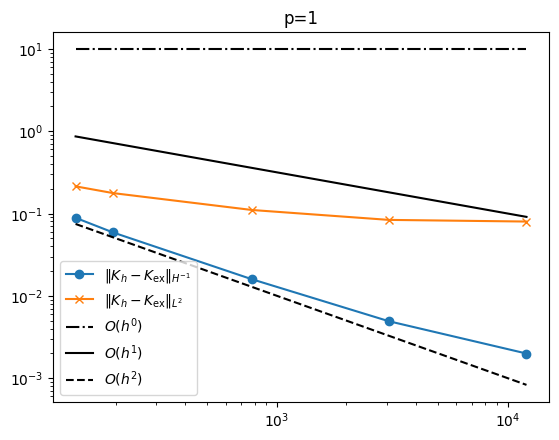

In [6]:
import matplotlib.pyplot as plt

plt.plot(ndof, errhm1, "-o", label="$\\|K_h-K_{\\mathrm{ex}}\\|_{H^{-1}}$")
plt.plot(ndof, errl2, "-x", label="$\\|K_h-K_{\\mathrm{ex}}\\|_{L^2}$")
plt.plot(
    ndof,
    [10**order * dof ** (-(order - 1) / 2) for dof in ndof],
    "-.",
    color="k",
    label="$O(h^" + str(order - 1) + ")$",
)
plt.plot(
    ndof,
    [10**order * dof ** (-(order) / 2) for dof in ndof],
    "-",
    color="k",
    label="$O(h^" + str(order) + ")$",
)
plt.plot(
    ndof,
    [10**order * dof ** (-(order + 1) / 2) for dof in ndof],
    "--",
    color="k",
    label="$O(h^" + str(order + 1) + ")$",
)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title(f"p={order}")
plt.show()